In [52]:
import math
import random
import numpy as np
from itertools import product

from qiskit import *

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from qiskit.utils import QuantumInstance

from qiskit.opflow import I, X, Y, Z
from qiskit.opflow import StateFn
from qiskit.opflow import Gradient
from qiskit.opflow import CircuitSampler
from qiskit.opflow.primitive_ops import MatrixOp

from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit.library.standard_gates import CRYGate

from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms.optimizers import GradientDescent
from qiskit.algorithms.optimizers import ADAM

from qiskit.providers.aer.noise import NoiseModel

from qiskit.quantum_info import Statevector
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

In [2]:
provider = IBMQ.load_account()

In [3]:
def rand_numb(low_in,high_in):
    return np.random.uniform(low=low_in, high=np.nextafter(high_in, np.inf))

#just to keep the upper limit included in the random number generation. 

In [93]:
numLayer = 3
numQubit = 4
global iterations
global noisy

In [94]:
#Create unitaries here
unitary_param_1 = np.array([])
for i in range(0, 12):
    unitary_param_1 = np.append(unitary_param_1, np.array([rand_numb(0,2*np.pi)]))

#unitary_param_1 = [2.10501732, 5.11015318, 1.02860258, 4.19873724, 4.92982797, 0.34386221, 0.36480756, 0.03715926, 
#                   0.26142496, 3.83355082, 2.72581293, 4.00028864]

In [95]:
print(unitary_param_1)

[6.03578783 0.23947994 0.77095901 3.473469   1.08374262 3.885584
 0.62963794 4.11986605 4.81630529 2.81829734 2.31310142 5.26866177]


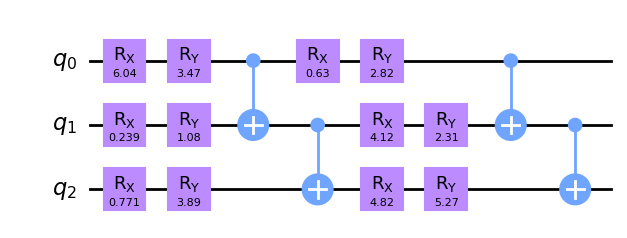

In [96]:
# First unitary
size = 3
layers = 2
state = QuantumCircuit(size)
for j in range(layers):
    for i in range(size):
        state.rx(unitary_param_1[j*size*2 + i], i)
        state.ry(unitary_param_1[j*2*size + i + size], i)

    for i in range(size-1):
        state.cx(i, i+1)

state.draw('mpl')

In [97]:
def createProver(numQubit, numLayer):
    numparam = numQubit*numLayer*2
    prover = QuantumCircuit(numQubit)
    param_vector = ParameterVector("params", numparam)
    
    for j in range(numLayer):
        for i in range(numQubit):
            prover.rx(param_vector[j*2*numQubit + i], i)
            prover.ry(param_vector[j*2*numQubit + i + numQubit], i)

        for i in range(numQubit-1):
            prover.cx(i, i+1)
            
    return prover

In [98]:
def createEqSuperpos2E():
    temp = QuantumCircuit(1)
    temp.h(0)
    return temp

In [99]:
def createWernerState(F):
    theta1 = 2*np.arccos(np.sqrt(0.667*(1-F)))
    theta2 = 2*np.arctan(np.sqrt(3*F/(1-F)))
    
    state = QuantumCircuit(3)
    state.ry(theta1, 0)
    state.append(CRYGate(theta2), [0, 1])
    state.x(0)
    state.ch(0, 1)
    state.x(0)
    
    return state

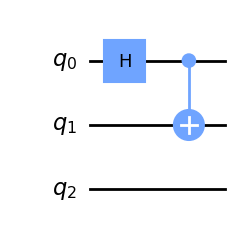

In [100]:
qcTest = QuantumCircuit(3)
qcTest.h(0)
qcTest.cx(0, 1)
qcTest.draw('mpl')

In [101]:
def createQuantumCircuit(state, numQubit, numLayer):
    circ = QuantumCircuit(7)
    #Create Quantum Circuit here
    
    superPosCircuit = createEqSuperpos2E()
    circ.append(superPosCircuit, [0])

    circ.append(state, [1, 2, 3])
    
    prover = createProver(numQubit, numLayer)
    circ.append(prover, [3, 4, 5, 6])
    
    circ.cswap(0, 2, 3)
    circ.cswap(0, 5, 6)
    
    circ.append(superPosCircuit.inverse(), [0])
    
    return circ

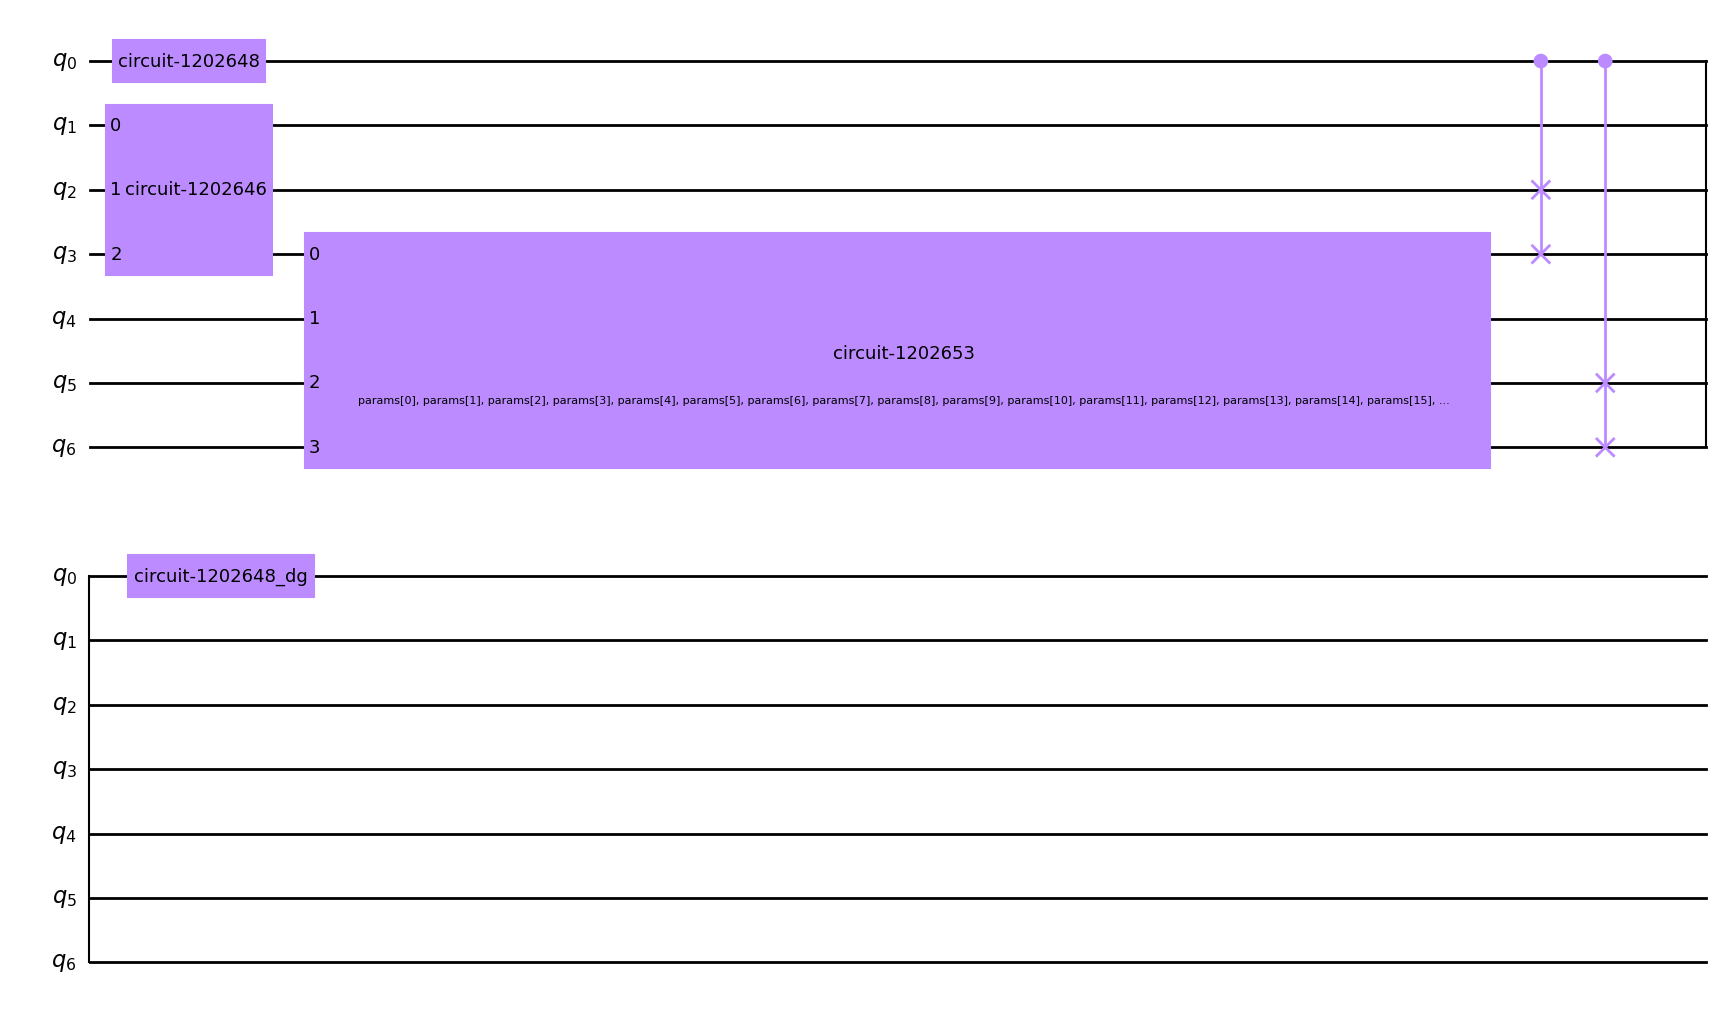

In [102]:
qCirc = createQuantumCircuit(createWernerState(0.5), numQubit, numLayer)
qCirc.draw('mpl')

In [103]:
#use if noiseless
noiseless_backend = Aer.get_backend('statevector_simulator')
noiseless_q_instance = QuantumInstance(noiseless_backend)
noiseless_sampler = CircuitSampler(noiseless_q_instance)

In [104]:
#Use if noisy
provider = IBMQ.get_provider(hub="ibm-q-research", group="louisiana-st-uni-1", project="main")
noisy_backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibm_lagos")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
noisy_q_instance = QuantumInstance(backend=noisy_backend, 
                           shots=8192, 
                           noise_model=noise_model, 
                           coupling_map=coupling_map,
                           measurement_error_mitigation_cls=CompleteMeasFitter,
                           cals_matrix_refresh_period=30)
noisy_sampler = CircuitSampler(noisy_q_instance)

In [105]:
#Create Hamiltonian here
hamiltonian = I^I^I^I^I^I^MatrixOp(np.array([[1, 0], [0, 0]]))

In [106]:
def costf(params):
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    
    if noisy:
        result = noisy_sampler.convert(expectation, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(expectation, params=value_dict).eval()  
    
    return -1*np.real(result)

In [107]:
def gradient(params):
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    gradient = Gradient().convert(expectation)
    
    if noisy:
        result = noisy_sampler.convert(gradient, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(gradient, params=value_dict).eval()  
    
    return -1*np.real(result)

In [108]:
print(qCirc.parameters)

ParameterView([ParameterVectorElement(params[0]), ParameterVectorElement(params[1]), ParameterVectorElement(params[2]), ParameterVectorElement(params[3]), ParameterVectorElement(params[4]), ParameterVectorElement(params[5]), ParameterVectorElement(params[6]), ParameterVectorElement(params[7]), ParameterVectorElement(params[8]), ParameterVectorElement(params[9]), ParameterVectorElement(params[10]), ParameterVectorElement(params[11]), ParameterVectorElement(params[12]), ParameterVectorElement(params[13]), ParameterVectorElement(params[14]), ParameterVectorElement(params[15]), ParameterVectorElement(params[16]), ParameterVectorElement(params[17]), ParameterVectorElement(params[18]), ParameterVectorElement(params[19]), ParameterVectorElement(params[20]), ParameterVectorElement(params[21]), ParameterVectorElement(params[22]), ParameterVectorElement(params[23])])


In [109]:
def autospsa_callback(nfev, x, fx, stepsize, accepted = False):
    if (noisy == True):
        noisy_loss.append(-1*fx)
    else:
        noiseless_loss.append(-1*fx)
    print("Loss Value : ", -1*fx, str(nfev/3)+"%")

In [110]:
numParam = 2*numQubit*numLayer
noisy = False
paramProver = []
for i in range(0, numParam):
    paramProver = np.append(paramProver, np.array([rand_numb(0,2*np.pi)]))
print(paramProver)

print("Initial Cost : ", -1*costf(paramProver))

[2.6195349  2.8973908  4.86310894 0.37538395 0.63286483 5.89635702
 5.44762969 4.23355634 1.63760604 3.77335804 1.90990121 1.18032195
 5.26885508 0.80693255 1.47720814 1.42055885 2.61208393 5.62275483
 3.6025343  1.46978805 5.71464546 1.08534723 1.5642204  4.7983204 ]
Initial Cost :  0.5158215729919322


In [111]:
true_value = 1.0

In [113]:
noisy = False
noiseless_loss = []
noiselessParam = np.copy(paramProver)
print("Initial Cost : ", -1*costf(noiselessParam))
autospsa = SPSA(maxiter=300, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noiselessParam)

Initial Cost :  0.5158215729919322
Loss Value :  0.565914769463064 1.0%
Loss Value :  0.621980724235478 2.0%
Loss Value :  0.6651317338344269 3.0%
Loss Value :  0.6680190774576996 4.0%
Loss Value :  0.7860951424159194 5.0%
Loss Value :  0.7706895030119281 6.0%
Loss Value :  0.6246524402650449 7.0%
Loss Value :  0.6045615237601059 8.0%
Loss Value :  0.6806406694776683 9.0%
Loss Value :  0.703365163090656 10.0%
Loss Value :  0.7142477584045335 11.0%
Loss Value :  0.732187884618592 12.0%
Loss Value :  0.7321756665567613 13.0%
Loss Value :  0.7454615488831264 14.0%
Loss Value :  0.7496614830813142 15.0%
Loss Value :  0.7855693248131114 16.0%
Loss Value :  0.7976767216237177 17.0%
Loss Value :  0.8055165252531364 18.0%
Loss Value :  0.8504673486221666 19.0%
Loss Value :  0.849025952887994 20.0%
Loss Value :  0.8366322769443046 21.0%
Loss Value :  0.8690108890960948 22.0%
Loss Value :  0.8687612316675388 23.0%
Loss Value :  0.8693077438658665 24.0%
Loss Value :  0.8693913951855516 25.0%
Loss

Loss Value :  0.9917608046493946 212.0%
Loss Value :  0.9917690951505637 213.0%
Loss Value :  0.9917743586150636 214.0%
Loss Value :  0.9917745702181899 215.0%
Loss Value :  0.9917717472079564 216.0%
Loss Value :  0.9917910423098306 217.0%
Loss Value :  0.9917934842087179 218.0%
Loss Value :  0.9918602977189268 219.0%
Loss Value :  0.9918870955661185 220.0%
Loss Value :  0.9918829638694966 221.0%
Loss Value :  0.9918826587400715 222.0%
Loss Value :  0.9918960517172957 223.0%
Loss Value :  0.9919092410356511 224.0%
Loss Value :  0.9919338979752277 225.0%
Loss Value :  0.9919380988658821 226.0%
Loss Value :  0.9919053077504378 227.0%
Loss Value :  0.9919328138324334 228.0%
Loss Value :  0.9919505138286819 229.0%
Loss Value :  0.9919381665886228 230.0%
Loss Value :  0.991937931860156 231.0%
Loss Value :  0.9919431504710112 232.0%
Loss Value :  0.9919415517602508 233.0%
Loss Value :  0.9919514362731443 234.0%
Loss Value :  0.9919421178029452 235.0%
Loss Value :  0.9919386046686749 236.0%
L

In [88]:
noisy = True
noisy_loss = []
noisyParam = np.copy(paramProver)
-1*costf(noisyParam)
print("Initial Cost : ", -1*costf(noisyParam))
autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noisyParam)

Initial Cost :  0.6536062358246525
Loss Value :  0.6738674155229432 1.0%
Loss Value :  0.7446731297837608 2.0%
Loss Value :  0.760063039587403 3.0%
Loss Value :  0.7332512210616073 4.0%
Loss Value :  0.7629438123081493 5.0%
Loss Value :  0.7310780681873197 6.0%
Loss Value :  0.7508296933915779 7.0%
Loss Value :  0.7384118920426797 8.0%
Loss Value :  0.7353219781335483 9.0%
Loss Value :  0.73848253583561 10.0%
Loss Value :  0.7330501302618467 11.0%
Loss Value :  0.7601509152174325 12.0%
Loss Value :  0.7291212951761761 13.0%
Loss Value :  0.7081687659086314 14.0%
Loss Value :  0.7392895568309987 15.0%
Loss Value :  0.7482501026929663 16.0%
Loss Value :  0.744668954922844 17.0%
Loss Value :  0.7583754872481714 18.0%
Loss Value :  0.7733589357965173 19.0%
Loss Value :  0.7528204145997961 20.0%
Loss Value :  0.782437743077476 21.0%
Loss Value :  0.7917714649974993 22.0%
Loss Value :  0.7701760693261795 23.0%
Loss Value :  0.7815936633731407 24.0%
Loss Value :  0.7898636897071952 25.0%
Loss

In [89]:
noisy = False
noiseResilientValue = -1*costf(x_opt)
print(noiseResilientValue)

0.9855714091462502


In [90]:
print("True Value : ", true_value)
print("Noiseless : ", noiseless_loss[-1])
print("Noisy : ", noisy_loss[-1])
print("Noise Resilient Value : ", noiseResilientValue)

True Value :  1.0
Noiseless :  0.9915424110888709
Noisy :  0.8997653099576767
Noise Resilient Value :  0.9855714091462502


In [91]:
def writeToFile():
    file = open("S2_GSE.txt", "w+")
    file.write(str(true_value)+"\n")
    file.write(str(noiseResilientValue)+"\n")

    file.write(str(len(noiseless_loss))+"\n")
    L = [str(i)+"\n" for i in noiseless_loss]
    file.writelines(L)
    
    file.write(str(len(noisy_loss))+"\n")
    L = [str(i)+"\n" for i in noisy_loss[0:len(noisy_loss)-1]]
    file.writelines(L)
    file.write(str(noisy_loss[-1]))
    
    file.close()

In [92]:
writeToFile()